In [1]:
suppressPackageStartupMessages(require(tidyverse))
suppressPackageStartupMessages(require(data.table))


In [2]:
outd <- file.path(getwd(), 'out')

traits <- fread('cascade.input.files.tsv')


In [3]:
array_anno_df <-
fread(cmd=paste('zstdcat', file.path(outd, 'cascade.array.hits.tsv.zst'), sep=' '), sep='\t')


In [4]:
array_anno_df %>% count(Csq)

Csq,n
<chr>,<int>
non-coding,85984
protein-altering,9307
protein-truncating,400


In [5]:
array_anno_df %>% colnames()

[1] "CHROM"             "POS"               "ID"               
 [4] "ALT"               "REF"               "Effect"           
 [7] "StdErr"            "P"                 "Direction"        
[10] "HetISq"            "HetChiSq"          "HetDf"            
[13] "HetPVal"           "name"              "maf"              
[16] "ld_indep"          "Gene_symbol"       "Gene"             
[19] "HGVSp"             "Csq"               "Consequence"      
[22] "is_outside_of_MHC" "is_rare"           "p_thr"

In [6]:
p.ptv <- array_anno_df %>% 
filter(Csq == 'protein-truncating', ld_indep, is_outside_of_MHC) %>%
mutate(
    outlier = if_else(abs(Effect) >= .1, TRUE, FALSE),
    ggrepel = if_else(abs(Effect) >= .1, Gene_symbol, "")
) %>%
ggplot(
    aes(x=maf, y=Effect, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point() + theme_bw() + 
labs(
    title = 'Protein-truncating variants',
    x = 'Minor allele frequency (log-scale)',
    y = 'BETAs'
) +
theme(
    strip.text = element_text(size=7),
    legend.position="none"
)+
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10 * 100**(-3:-1)) + 
facet_wrap(~name, ncol = 6, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2)


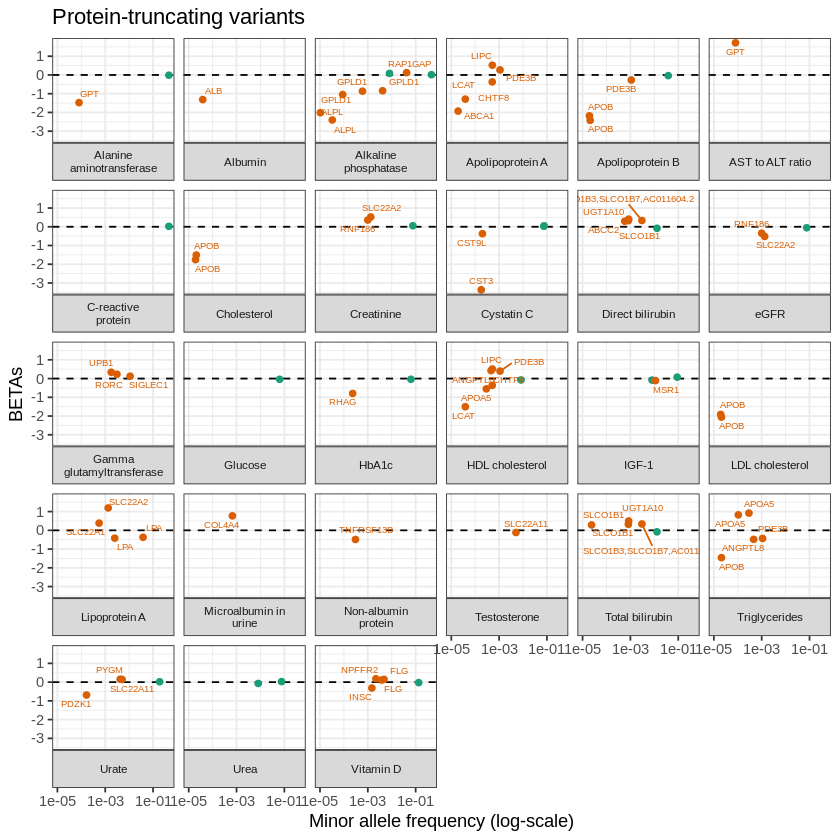

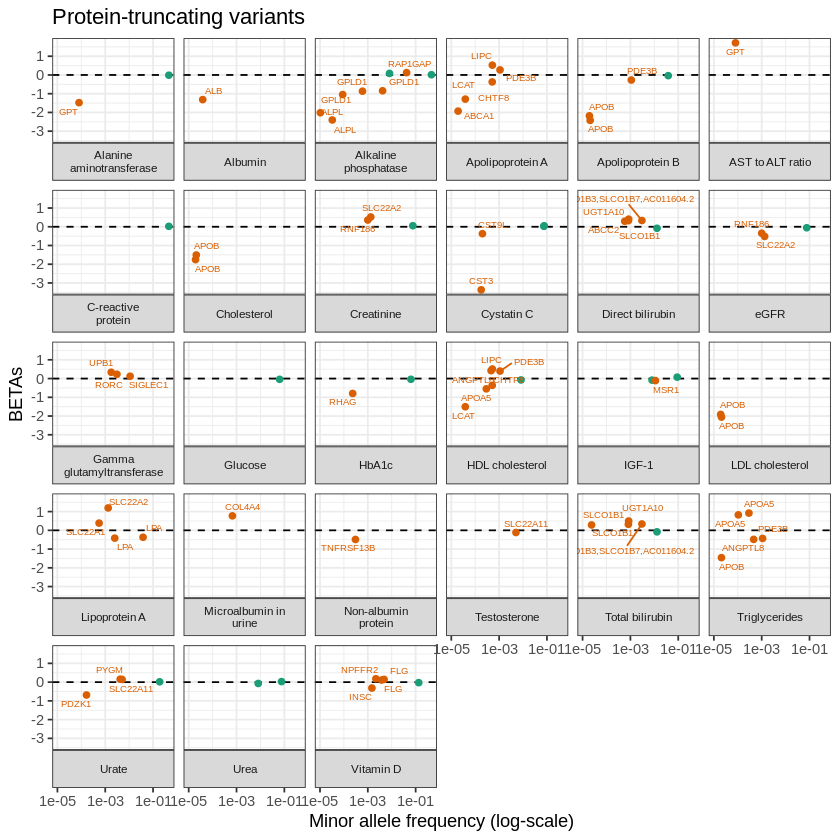

In [7]:
p.ptv + ggsave(file.path(outd, "cascade.PTVs.png"), width = 10, height = 10)
p.ptv + ggsave(file.path(outd, "cascade.PTVs.pdf"), width = 10, height = 10)


In [8]:
p.altering <- array_anno_df %>% 
filter(Csq == 'protein-altering', ld_indep, is_outside_of_MHC) %>%
mutate(
    outlier = if_else(abs(Effect) >= .1, TRUE, FALSE),
    ggrepel = if_else(abs(Effect) >= .5, Gene_symbol, "")
) %>%
ggplot(
    aes(x=maf, y=Effect, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point() + theme_bw() + 
labs(
    title = 'Protein-altering variants',
    x = 'Minor allele frequency (log-scale)',
    y = 'BETAs'
) +
theme(
    strip.text = element_text(size=7),
    legend.position="none"
)+
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10 * 100**(-3:-1)) + 
facet_wrap(~name, ncol = 6, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2)


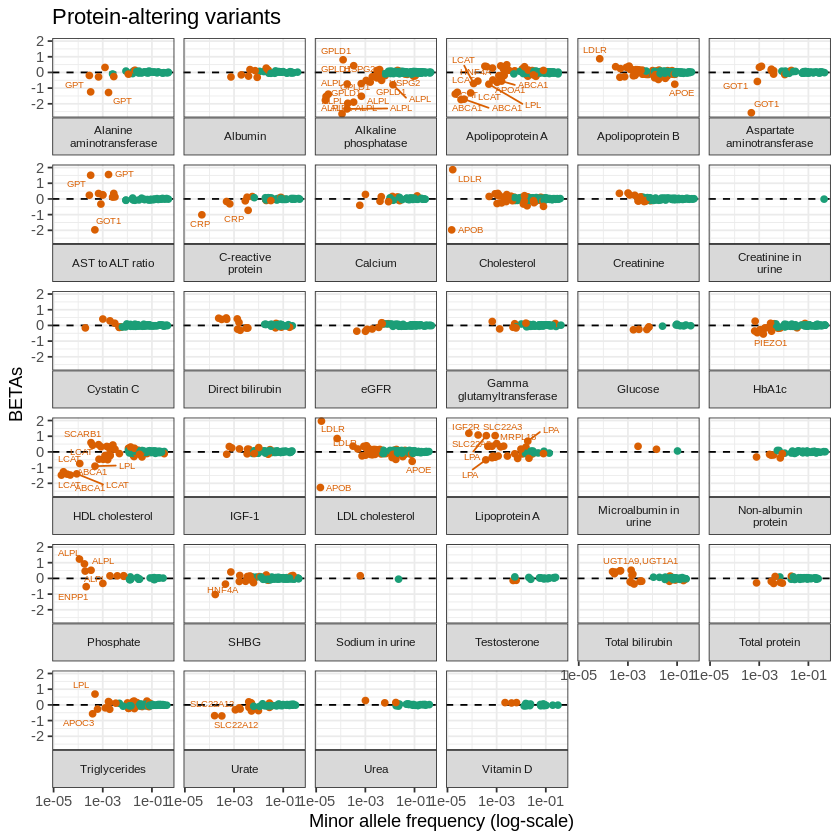

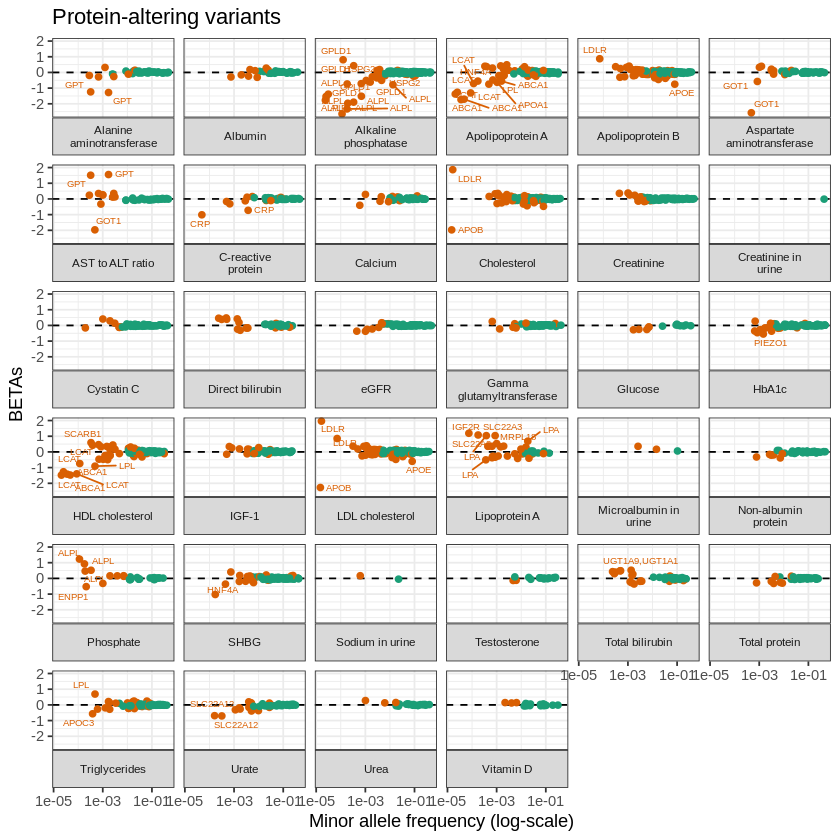

In [9]:
p.altering + ggsave(file.path(outd, "cascade.protein-altering.png"), width = 10, height = 10)
p.altering + ggsave(file.path(outd, "cascade.protein-altering.pdf"), width = 10, height = 10)


In [10]:
p.array.nc <- array_anno_df %>% 
filter(Csq == 'non-coding', ld_indep, is_outside_of_MHC) %>%
mutate(
    outlier = if_else(abs(Effect) >= .1, TRUE, FALSE),
    plot_label = paste0(ID, ' (', Gene_symbol, ')'),
#     plot_label = ID,
    plot_label = str_replace(plot_label, '[(][)]$', ''),
    plot_label = str_replace(plot_label, '[(]NA[)]$', ''),    
    ggrepel = if_else(abs(Effect) >= .1, plot_label, ""),    
    ggrepel = if_else(abs(Effect) >= .5, plot_label, "")
) %>%
ggplot(
    aes(x=maf, y=Effect, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point() + theme_bw() + 
labs(
    title = 'Non-coding variants on array',
    x = 'Minor allele frequency (log-scale)',
    y = 'BETAs'
) +
theme(
    strip.text = element_text(size=7),
    legend.position="none"
)+
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10 * 100**(-3:-1)) + 
facet_wrap(~name, ncol = 6, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2)


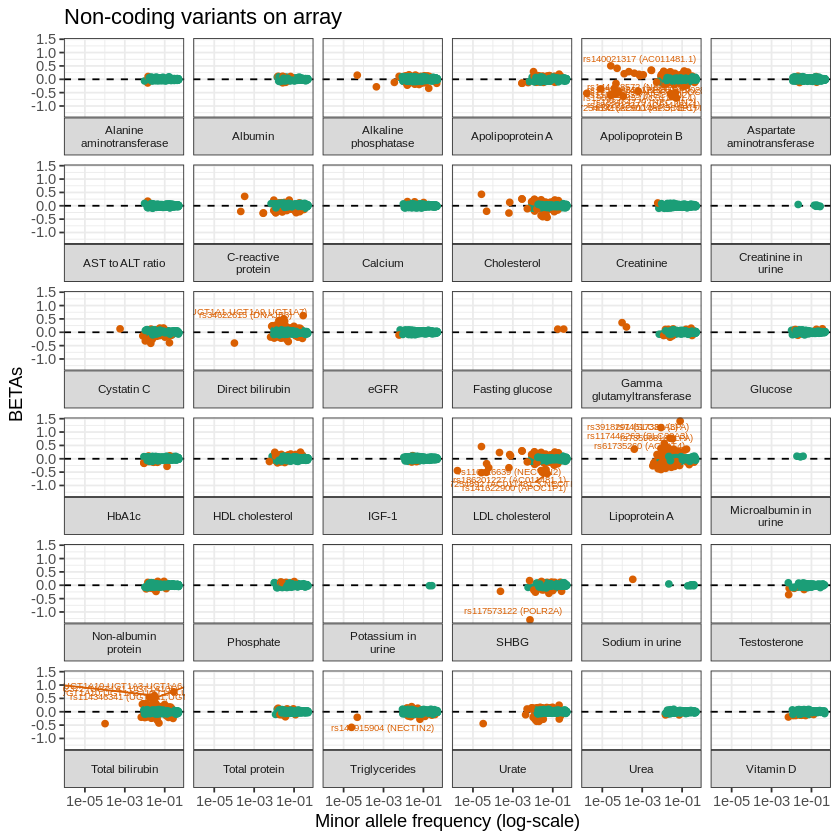

In [11]:
p.array.nc